# Train and visualize VAE

In [1]:
#@title import libraries and modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K

In [2]:
#@title load data (Fashion MNIST)
(x_train, y_train), (_, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
#@title reshape data for VAE
x_train = x_train.reshape(-1, 784)

# check the shape
x_train.shape

(60000, 784)

In [4]:
#@title normalize data
x_train = x_train / 255.

In [5]:
## Define VAE model

# define dimensions of latent variable
latent_dim = 2

# create sampling layer
class Reparameterize(Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        eps = K.random_normal(shape=(batch, dim))

        return z_mean + tf.exp(0.5 * z_logvar) * eps
        
# create VAE model
class VAE(Model):
    def __init__(self, with_kl_loss=True, with_mse_loss=False):
        # layer definition
        super(VAE, self).__init__()

        self.encoder = self._create_encoder(latent_dim)
        self.decoder = self._create_decoder(latent_dim)

        self.kl_loss = Mean()
        self.mse_loss = Mean()
        self.reconstruction_loss = Mean()
        self.total_loss = Mean()

        self.with_kl_loss = with_kl_loss
        self.with_mse_loss = with_mse_loss

    def _create_encoder(self, latent_dim):
        # define encoder
        input_layer = Input((784,))
        hidden_layer = Dense(100, activation='relu')(input_layer)
        z_mean = Dense(latent_dim)(hidden_layer)
        z_logvar = Dense(latent_dim)(hidden_layer)
        z = Reparameterize()([z_mean, z_logvar])

        return Model(input_layer, [z_mean, z_logvar, z])

    def _create_decoder(self, latent_dim):
        # define decoder
        latent_input = Input((latent_dim,))
        hidden_layer = Dense(100, activation='relu')(latent_input)
        output_layer = Dense(784, activation='sigmoid')(hidden_layer)

        return Model(latent_input, output_layer)

    
    @property
    def metrics(self):
        return [
                self.total_loss,
                self.reconstruction_loss,
                self.kl_loss,
                self.mse_loss
        ]
        

    def train_step(self, inputs):
        # define training
        with tf.GradientTape() as tape:
            # pass input to encoder
            z_mean, z_logvar, z = self.encoder(inputs)
            outputs = self.decoder(z)

            # calculate reconstruction_loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(binary_crossentropy(inputs, outputs), axis=-1) 
            )

            # calculate kld_loss
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar)), 
                    axis=-1
                )
            )

            # calculate mse_loss
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    mean_squared_error(z_logvar, tf.ones([batch, dim], dtype=tf.float32)) +  \
                        mean_squared_error(z_mean, tf.zeros([batch, dim], dtype=tf.float32)), 
                    axis=-1) 
            )

            # determine if VAE model uses kld_loss or not
            if not self.with_kl_loss:
                kl_loss = 0

            # determine if VAE model uses mse_loss or not
            if not self.with_mse_loss:
                mse_loss = 0

            # calculate total loss
            total_loss = reconstruction_loss + kl_loss + mse_loss

            # backpropagate error
            grads = tape.gradient(total_loss, self.trainable_weights)

            # update weights
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            # update losses
            self.total_loss.update_state(total_loss)
            self.reconstruction_loss.update_state(reconstruction_loss)
            self.kl_loss.update_state(kl_loss)
            self.mse_loss.update_state(mse_loss)

            return {
                "loss": self.total_loss.result(),
                "reconstruction_loss": self.reconstruction_loss.result(),
                "kl_loss": self.kl_loss.result(),
                "mse_loss": self.mse_loss.result()
            }

In [6]:
# create VAE model
vae_model = VAE()

In [7]:
# complie model
vae_model.compile(optimizer=Adam(learning_rate=0.0001))

In [8]:
# train model
vae_model.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 5s 6ms/step - loss: 83.0669 - reconstruction_loss: 81.2868 - kl_loss: 1.7802 - mse_loss: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 62.7484 - reconstruction_loss: 58.0401 - kl_loss: 4.7083 - mse_loss: 0.0000e+00
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 56.0201 - reconstruction_loss: 51.9424 - kl_loss: 4.0777 - mse_loss: 0.0000e+00
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 53.3691 - reconstruction_loss: 49.7661 - kl_loss: 3.6030 - mse_loss: 0.0000e+00
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 51.9707 - reconstruction_loss: 48.6213 - kl_loss: 3.3494 - mse_loss: 0.0000e+00
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 51.3883 - reconstruction_loss: 48.1605 - kl_loss: 3.2279 - mse_loss: 0.0000e+00
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 50

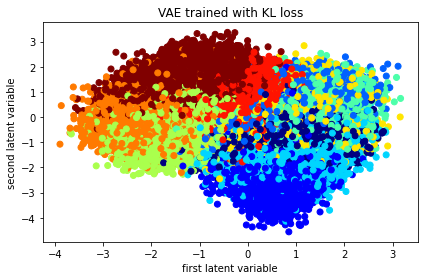

In [9]:
# plot latent space
z_mean, z_logvar, z = vae_model.encoder.predict(x_train)

plt.scatter(z[:, 0], z[:, 1], c=y_train, cmap='jet')

plt.xlabel('first latent variable')
plt.ylabel('second latent variable')
plt.title('VAE trained with KL loss')
plt.tight_layout()

plt.show()

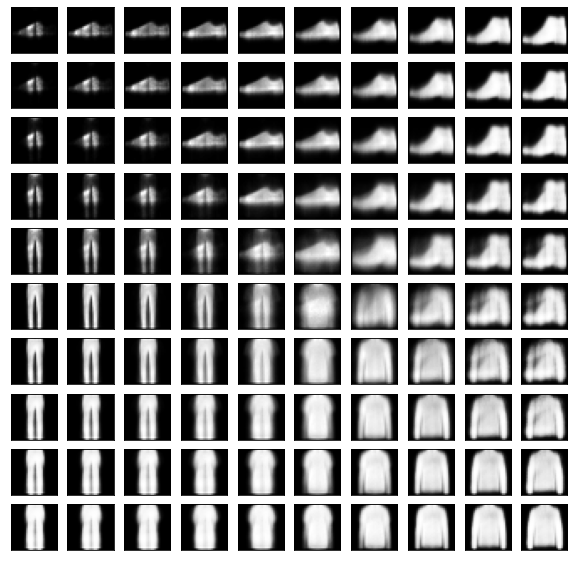

In [10]:
# generate images
m1, m2 = z[:, 0].min(), z[:, 0].max()
m3, m4 = z[:, 1].min(), z[:, 1].max()

random_features = np.mgrid[m1:m2:10j, m3:m4:10j].reshape(2,-1).T
gen_imgs = (np.clip(vae_model.decoder.predict(random_features), 0, 1) * 255).astype(int)

plt.figure(figsize=(10, 10))

for idx, img in enumerate(gen_imgs):
    plt.subplot(10, 10, idx+1)
    plt.imshow(img.reshape((28, 28)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [11]:
# memory size of original data (in MBs)
x_train.nbytes / 1024**2

358.88671875

In [12]:
# memory size of compressed data (in MBs)
z.nbytes / 1024**2

0.457763671875

# Train VAE without KL loss

In [13]:
# create VAE model
vae_model_2 = VAE(with_kl_loss=False)

# complie model
vae_model_2.compile(optimizer=Adam(learning_rate=0.0001))

# train model
vae_model_2.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 74.7577 - reconstruction_loss: 74.7577 - kl_loss: 0.0000e+00 - mse_loss: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 53.6894 - reconstruction_loss: 53.6894 - kl_loss: 0.0000e+00 - mse_loss: 0.0000e+00
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 49.6395 - reconstruction_loss: 49.6395 - kl_loss: 0.0000e+00 - mse_loss: 0.0000e+00
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 48.0850 - reconstruction_loss: 48.0850 - kl_loss: 0.0000e+00 - mse_loss: 0.0000e+00
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 47.0622 - reconstruction_loss: 47.0622 - kl_loss: 0.0000e+00 - mse_loss: 0.0000e+00
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 46.5887 - reconstruction_loss: 46.5887 - kl_loss: 0.0000e+00 - mse_loss: 0.0000e+00
Epoch 7/10
469/469 [==============================] 

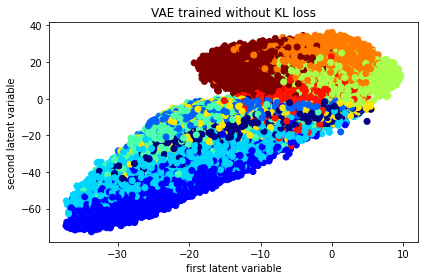

In [14]:
# plot latent space
z_mean, z_logvar, z = vae_model_2.encoder.predict(x_train)

plt.scatter(z[:, 0], z[:, 1], c=y_train, cmap='jet')

plt.xlabel('first latent variable')
plt.ylabel('second latent variable')
plt.title('VAE trained without KL loss')
plt.tight_layout()

plt.show()

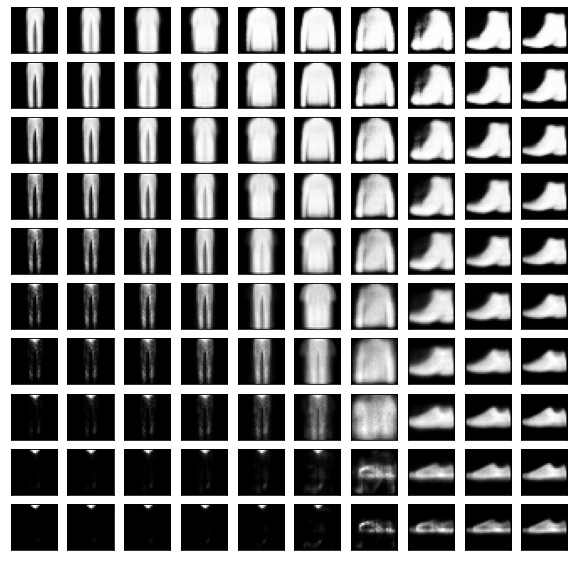

In [15]:
# generate images
m1, m2 = z[:, 0].min(), z[:, 0].max()
m3, m4 = z[:, 1].min(), z[:, 1].max()

random_features = np.mgrid[m1:m2:10j, m3:m4:10j].reshape(2,-1).T
gen_imgs = (np.clip(vae_model_2.decoder.predict(random_features), 0, 1) * 255).astype(int)

plt.figure(figsize=(10, 10))

for idx, img in enumerate(gen_imgs):
    plt.subplot(10, 10, idx+1)
    plt.imshow(img.reshape((28, 28)), cmap='gray')
    plt.xticks([])
    plt.yticks([])

# Train VAE with MSE loss instead of KL loss

In [16]:
# create VAE model
vae_model_3 = VAE(with_kl_loss=False, with_mse_loss=True)

# complie model
vae_model_3.compile(optimizer=Adam(learning_rate=0.0001))

# train model
vae_model_3.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 116.3349 - reconstruction_loss: 84.3904 - kl_loss: 0.0000e+00 - mse_loss: 31.9445
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 77.0903 - reconstruction_loss: 70.3255 - kl_loss: 0.0000e+00 - mse_loss: 6.7648
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 70.0437 - reconstruction_loss: 65.8560 - kl_loss: 0.0000e+00 - mse_loss: 4.1877
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 67.2291 - reconstruction_loss: 64.4125 - kl_loss: 0.0000e+00 - mse_loss: 2.8166
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 65.8415 - reconstruction_loss: 63.9083 - kl_loss: 0.0000e+00 - mse_loss: 1.9331
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 64.8413 - reconstruction_loss: 63.5225 - kl_loss: 0.0000e+00 - mse_loss: 1.3188
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 

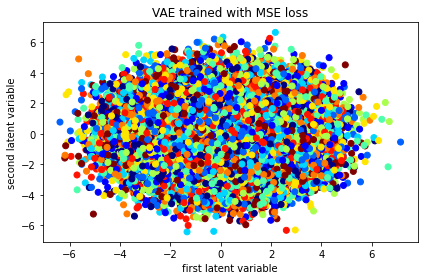

In [17]:
# plot latent space
z_mean, z_logvar, z = vae_model_3.encoder.predict(x_train)

plt.scatter(z[:, 0], z[:, 1], c=y_train, cmap='jet')

plt.xlabel('first latent variable')
plt.ylabel('second latent variable')
plt.title('VAE trained with MSE loss')
plt.tight_layout()

plt.show()

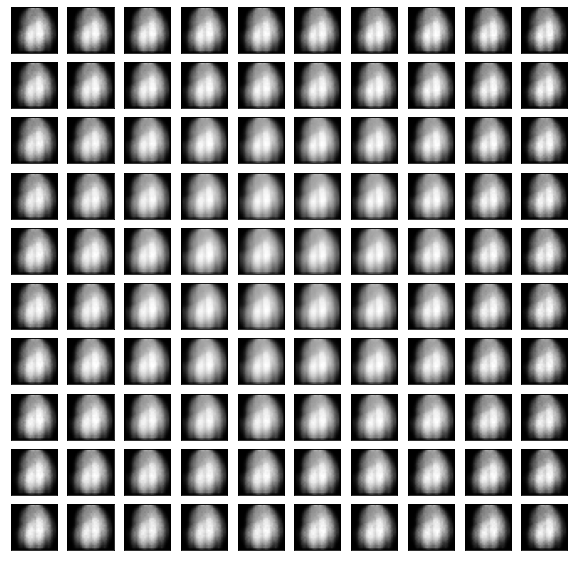

In [18]:
# generate images
m1, m2 = z[:, 0].min(), z[:, 0].max()
m3, m4 = z[:, 1].min(), z[:, 1].max()

random_features = np.mgrid[m1:m2:10j, m3:m4:10j].reshape(2,-1).T
gen_imgs = (np.clip(vae_model_3.decoder.predict(random_features), 0, 1) * 255).astype(int)

plt.figure(figsize=(10, 10))

for idx, img in enumerate(gen_imgs):
    plt.subplot(10, 10, idx+1)
    plt.imshow(img.reshape((28, 28)), cmap='gray')
    plt.xticks([])
    plt.yticks([])